<a href="https://colab.research.google.com/github/vicmcl/malaria-detection/blob/main/malaria-detection/notebook_malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

## **Imports**

### **Import Repo**

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
!git clone https://github.com/vicmcl/malaria-detection.git

Cloning into 'malaria-detection'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 178 (delta 101), reused 110 (delta 59), pack-reused 0
Receiving objects: 100% (178/178), 1.29 MiB | 1.86 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [76]:
from pathlib import Path

CONTENT_PATH = Path("/content")
PROJECT_PATH = CONTENT_PATH / "malaria-detection"
SRC_PATH = PROJECT_PATH / "malaria-detection"

In [83]:
!cd {PROJECT_PATH} && git pull origin main

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), 404 bytes | 404.00 KiB/s, done.
From https://github.com/vicmcl/malaria-detection
 * branch            main       -> FETCH_HEAD
   250fae6..76802ad  main       -> origin/main
Updating 250fae6..76802ad
Fast-forward
 malaria-detection/utils/plots.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)


In [5]:
import os
os.chdir(SRC_PATH)

### **Import Dataset**

In [6]:
from google.colab import userdata

username = userdata.get('KAGGLE_USERNAME')
api_key = userdata.get('KAGGLE_KEY')

In [7]:
import subprocess
import json

KAGGLE_CONFIG_DIR = os.path.join(os.path.expandvars('$HOME'), '.kaggle')
os.makedirs(KAGGLE_CONFIG_DIR, exist_ok = True)
api_dict = {"username":username, "key":api_key}

with open(f"{KAGGLE_CONFIG_DIR}/kaggle.json", "w", encoding='utf-8') as f:
    json.dump(api_dict, f)

cmd = f"chmod 600 {KAGGLE_CONFIG_DIR}/kaggle.json"
output = subprocess.check_output(cmd.split(" "))
output = output.decode(encoding='UTF-8')

In [8]:
!python utils/get_dataset.py

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria


### **Import Libraries**

In [9]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00


In [10]:
from utils.checkpoint import checkpoint
from utils.plots import plot_images, plot_training, settings
from utils.prediction import prediction
from utils.preprocessing import preprocess_data

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns

DATA_PATH = os.path.abspath("data/cell_images")
settings()

### **Mount Drive**

In [75]:
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive')
DRIVE_PATH = Path("/content/drive/MyDrive/")
ML_PATH = DRIVE_PATH / "Projects" / "malaria-detection"

WEIGHT_PATH = ML_PATH / "weights"
HISTORIES_PATH = ML_PATH / "histories"

Mounted at /content/drive


## **Preprocessing**

### **Train Test Split**

In [12]:
x_train, x_test, y_train, y_test = preprocess_data(DATA_PATH)

In [13]:
print(x_train.shape)
print(x_test.shape)

(22046, 64, 64, 3)
(5512, 64, 64, 3)


### **Proportion of Uninfected / Parasitized**

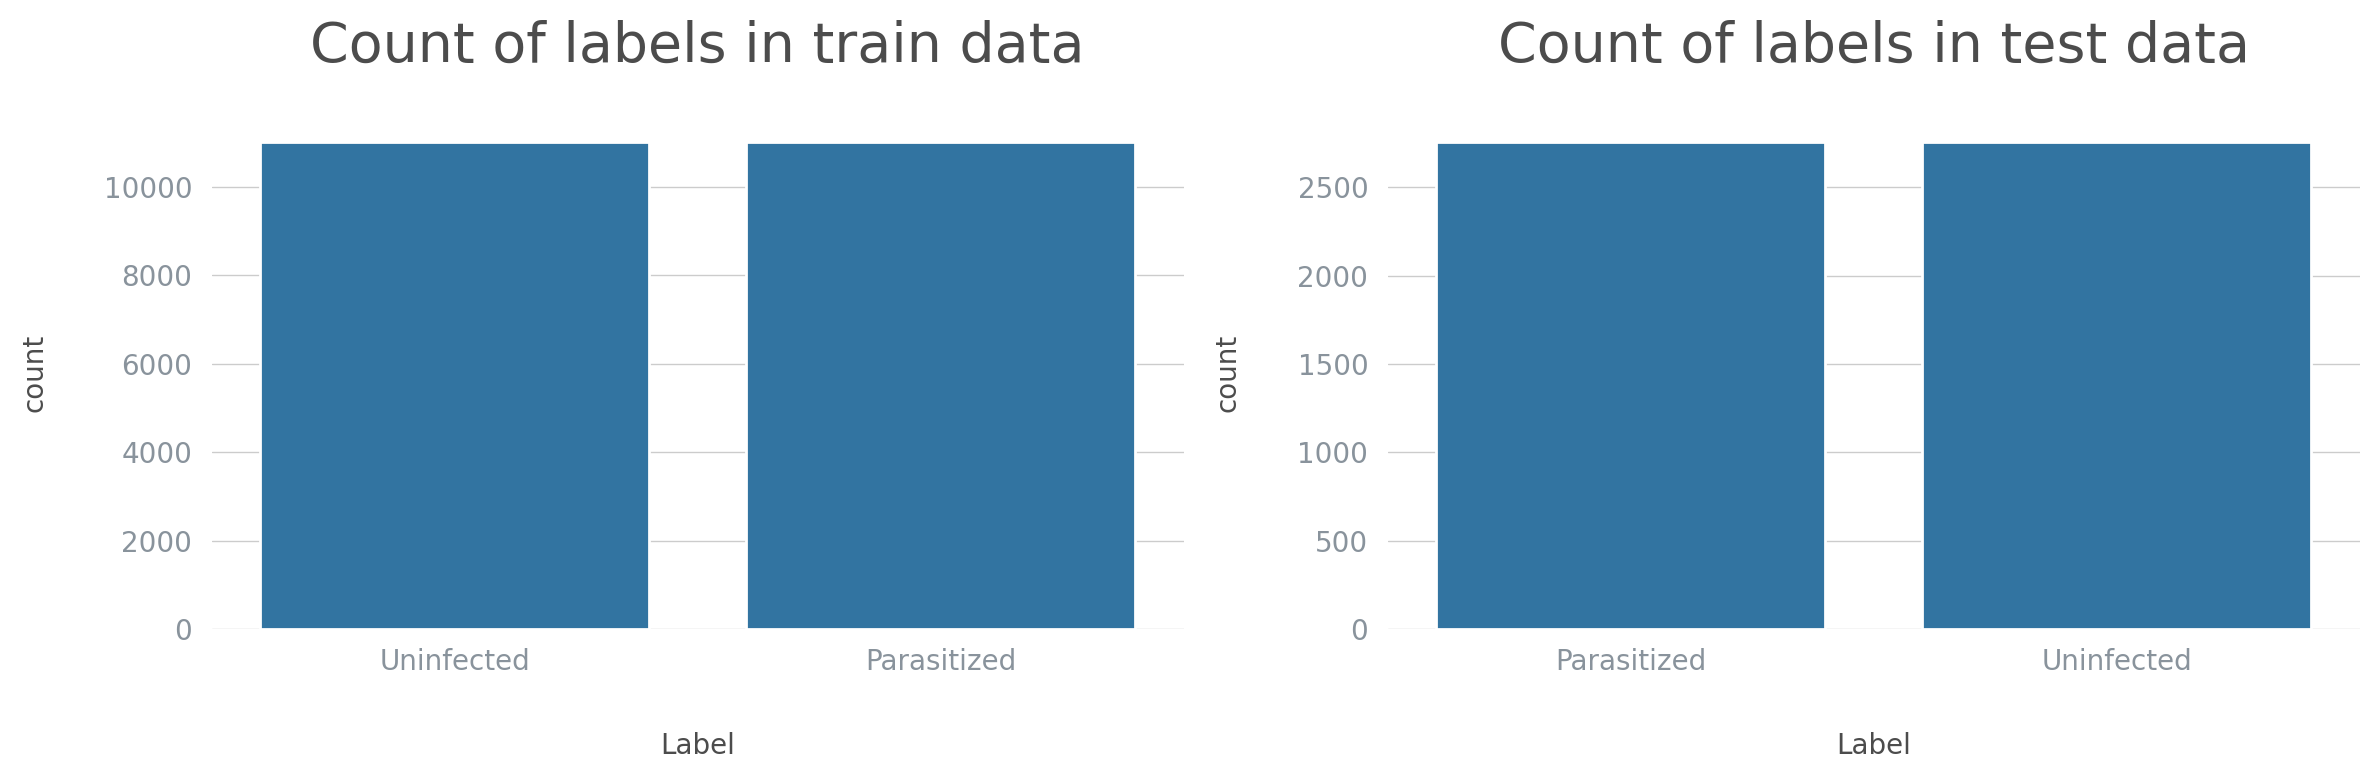

In [19]:
fig = plt.figure(figsize = (12, 4))
labels = ["Uninfected", "Parasitized"]

# Create two dataframe to associate each image with its label
for i, data in enumerate([(x_train, y_train), (x_test, y_test)]):
    df = pd.DataFrame(
        zip(data[0], data[1]), columns = ["Image", "Label"]
    )
    fig.add_subplot(1, 2, i + 1)
    for j, lab in enumerate(labels):
        df["Label"] = df["Label"].replace(j, lab)

    # Plot the countplot of labels in df_train
    sns.countplot(data = df, x = "Label")

    title = "train" if i == 0 else "test"
    plt.gca().set_title(f"Count of labels in {title} data")

plt.tight_layout()
plt.show()

- The training dataset is well balanced with a 50/50 split between the images of parasitized and uninfected cells. Therefore, the models should be able to train on a similar number of images of parasitized and uninfected cells, which is likely to improve the results against new data.

### **Visualization**

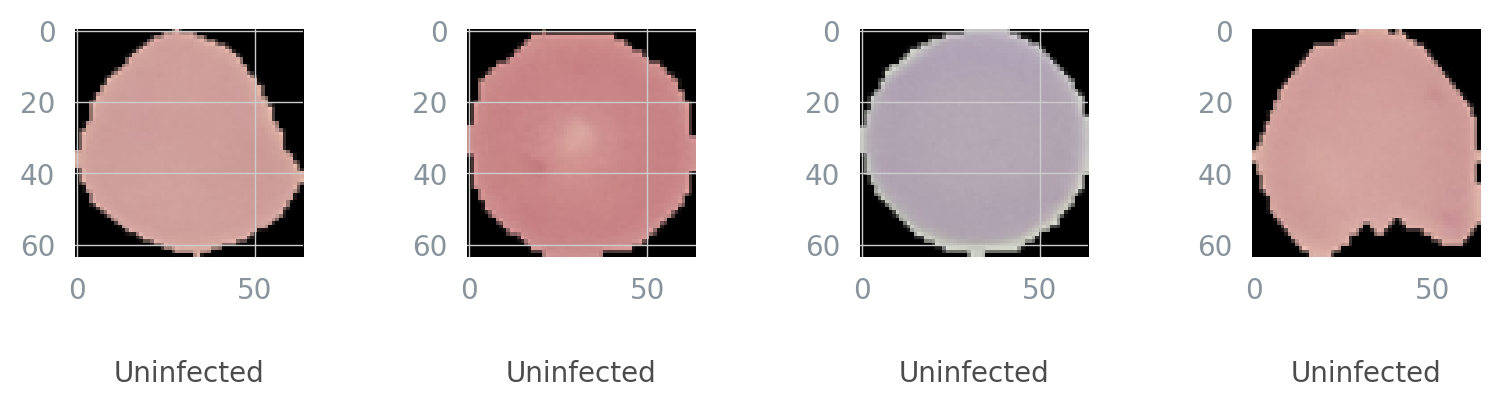

In [20]:
plot_images(x_train, y_train, 4)

## **CNN**

In [14]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.math import confusion_matrix
from tensorflow.random import set_seed

from tensorflow.keras import backend, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    LeakyReLU,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
)


### **One Hot Encoding Labels**

In [15]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

#### **Plotting the confusion matrix**

In [16]:
def report_and_matrix(test, pred):
    # Print the classification report
    report = classification_report(test, pred)

    print(report)
    print("----------------------------------------------------------------------")
    print()

    # Plot the confusion matrix
    cm = confusion_matrix(test, pred)
    ax = sns.heatmap(
            cm,
            annot = True,
            linewidths = 0.4,
            fmt = "d",
            square = True,
         )

    ax.set(
        xlabel = 'Predicted Labels',
        ylabel = 'True Labels',
    )

    plt.show()

    # Return the report and the confusion matrix in a dictionary
    return {"report": report, "matrix": cm}

In [17]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
set_seed(42)

#### **Building the model**

In [18]:
histories = {}

In [59]:
# Sequential model
model = Sequential(
    name = "Light_CNN",
    layers = [
        Input(shape = (64, 64, 3)),
        Conv2D(
            filters = 32,
            kernel_size = 2,
            padding = "same",
            activation = "relu",
        ),
        MaxPooling2D(pool_size = 2),
        Dropout(rate = 0.3),
        Conv2D(
            filters = 64,
            kernel_size = 2,
            padding = "same",
            activation = "relu",
        ),
        MaxPooling2D(pool_size = 2),
        Dropout(rate = 0.3),
        Flatten(),
        Dense(units = 128, activation = "relu"),
        Dropout(rate = 0.5),
        Dense(2, activation = 'softmax')
    ]
)

model.summary()
model.compile(
    loss="binary_crossentropy",
    optimizer = Adam(learning_rate = 0.0005),
    metrics = ["accuracy"]
)

history = model.fit(
    x_train,
    y_train_encoded,
    epochs = 100,
    callbacks = checkpoint(
        WEIGHT_PATH / "weights_light_cnn.keras", patience = 3
    ),
    validation_split = 0.2,
    batch_size = 32,
    verbose = 1
)

Model: "Light_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0 

In [60]:
histories["Light_CNN"] = history

#### **Plotting the train and the validation curves**

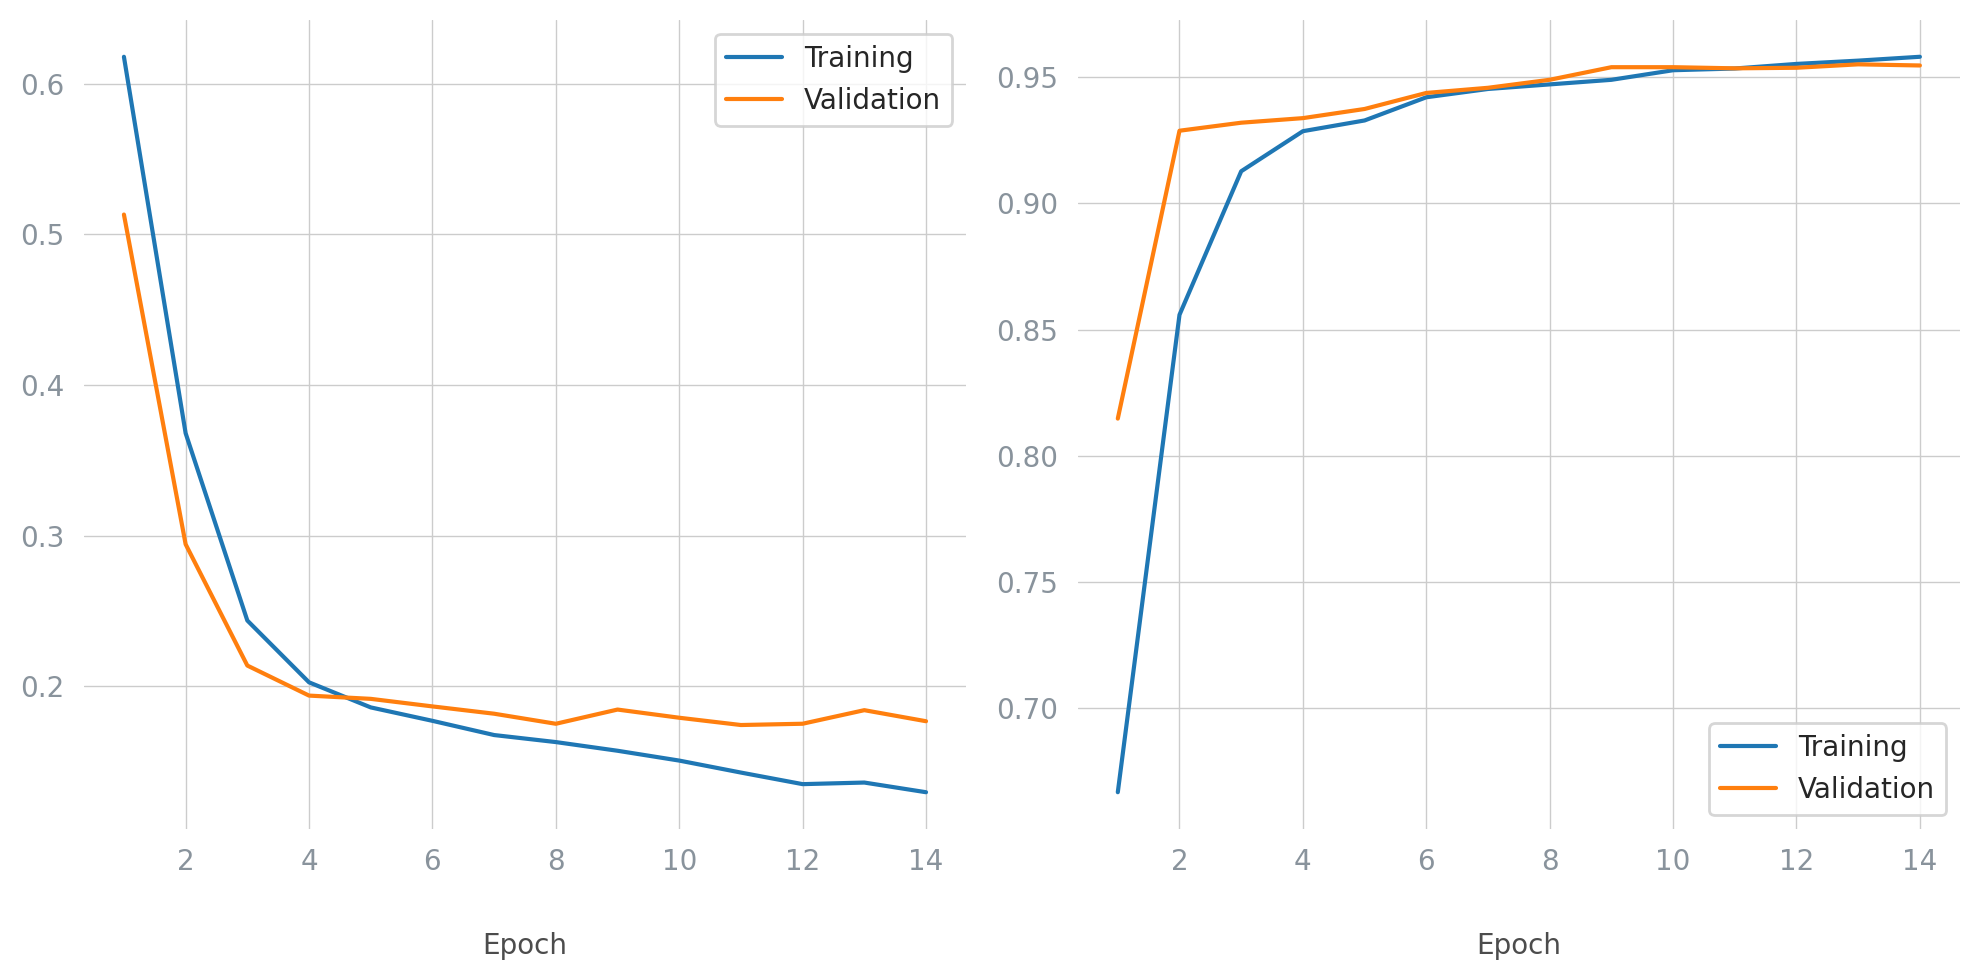

In [61]:
plot_training(history)

#### **Evaluating the model**

In [62]:
test_1, pred_1 = prediction(model, x_test, y_test_encoded)

173/173 [==============================] - 1s 3ms/step


#### **Plotting the confusion matrix**

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2756
           1       0.96      0.94      0.95      2756

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512

----------------------------------------------------------------------



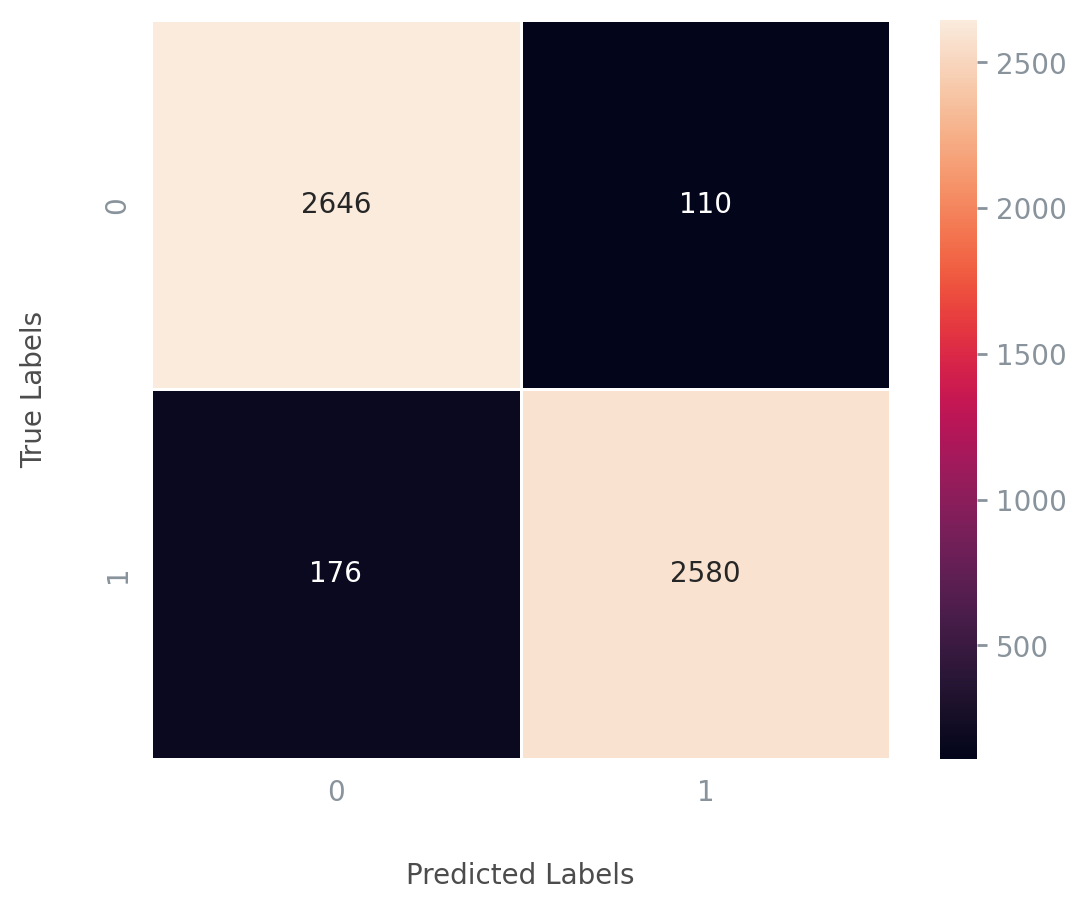

In [63]:
stat_1 = report_and_matrix(test_1, pred_1)

## **Data Augmentation**

In [64]:
model_aug = clone_model(model)
model_aug.compile(
    loss="binary_crossentropy",
    optimizer = Adam(learning_rate = 0.0005),
    metrics = ["accuracy"]
)

In [19]:
# Parameters to generate new images
train_generator = ImageDataGenerator(
    horizontal_flip=True, # Can flip the image upside down
    zoom_range=0.5,       # Can zoom in the image up to 2x
    rotation_range=30,     # Can rotate the image up to 30°
    validation_split = 0.2
)
val_generator = ImageDataGenerator(validation_split = 0.2)

# Create an iterator with new images
augmented_train_data = train_generator.flow(
    x = x_train,
    y = y_train_encoded,
    batch_size = 32,
    seed = 42,
    shuffle = True,
    subset = "training"
)

val_data = val_generator.flow(
    x = x_train,
    y = y_train_encoded,
    batch_size = 32,
    seed = 42,
    shuffle = True,
    subset = "validation"
)

In [65]:
history_augmented = model_aug.fit(
    augmented_train_data,
    epochs = 100,
    callbacks = checkpoint(
        WEIGHT_PATH / "weights_light_cnn.keras", patience = 3
    ),
    validation_data = val_data,
    verbose = 1
)

Epoch 1/100
552/552 [==============================] - 22s 37ms/step - loss: 0.6730 - accuracy: 0.5864 - val_loss: 0.6518 - val_accuracy: 0.7061
Epoch 2/100
552/552 [==============================] - 20s 37ms/step - loss: 0.6187 - accuracy: 0.6768 - val_loss: 0.5822 - val_accuracy: 0.7419
Epoch 3/100
552/552 [==============================] - 21s 37ms/step - loss: 0.5181 - accuracy: 0.7783 - val_loss: 0.3500 - val_accuracy: 0.9011
Epoch 4/100
552/552 [==============================] - 20s 37ms/step - loss: 0.3658 - accuracy: 0.8566 - val_loss: 0.2382 - val_accuracy: 0.9183
Epoch 5/100
552/552 [==============================] - 20s 36ms/step - loss: 0.3178 - accuracy: 0.8859 - val_loss: 0.2072 - val_accuracy: 0.9252
Epoch 6/100
552/552 [==============================] - 21s 37ms/step - loss: 0.3031 - accuracy: 0.8970 - val_loss: 0.1995 - val_accuracy: 0.9290
Epoch 7/100
552/552 [==============================] - 20s 37ms/step - loss: 0.2853 - accuracy: 0.9037 - val_loss: 0.1863 - val_ac

In [66]:
histories["Light_CNN_augmented"] = history_augmented

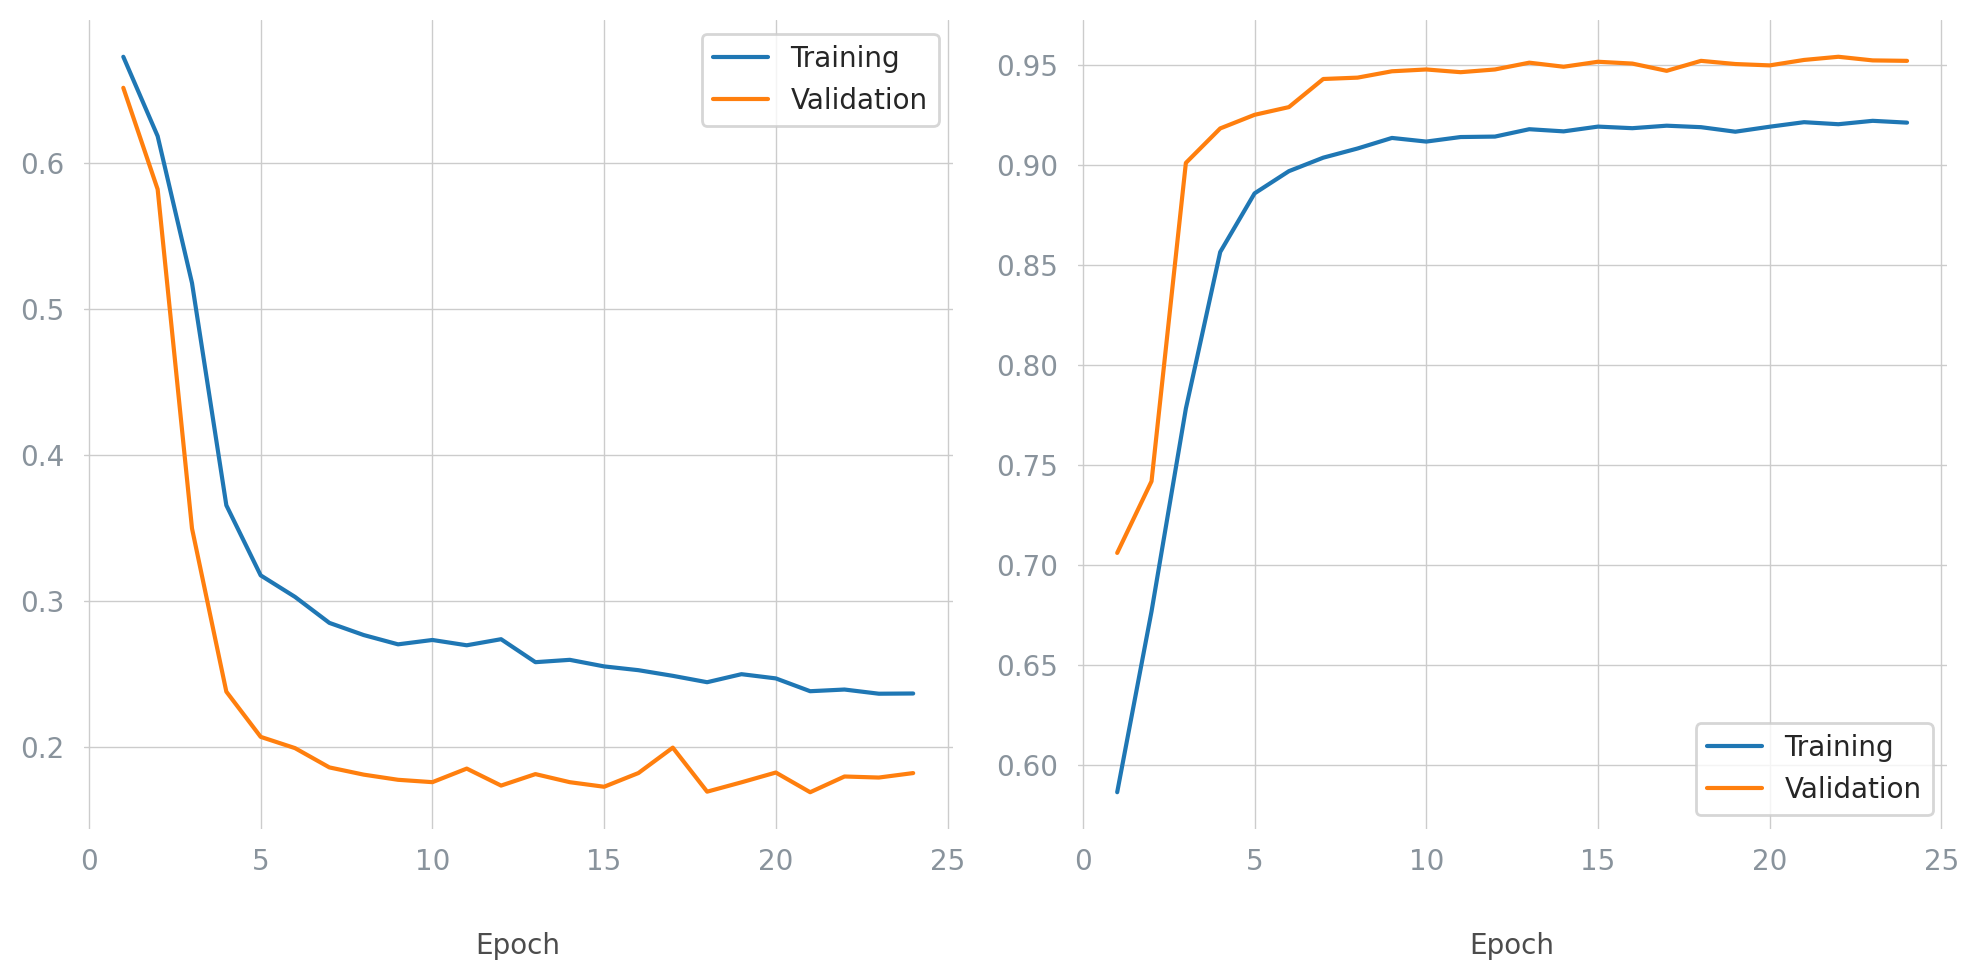

In [67]:
plot_training(history_augmented)

In [68]:
test_2, pred_2 = prediction(model_aug, x_test, y_test_encoded)

173/173 [==============================] - 0s 2ms/step


              precision    recall  f1-score   support

           0       0.92      0.98      0.95      2756
           1       0.98      0.92      0.95      2756

    accuracy                           0.95      5512
   macro avg       0.95      0.95      0.95      5512
weighted avg       0.95      0.95      0.95      5512

----------------------------------------------------------------------



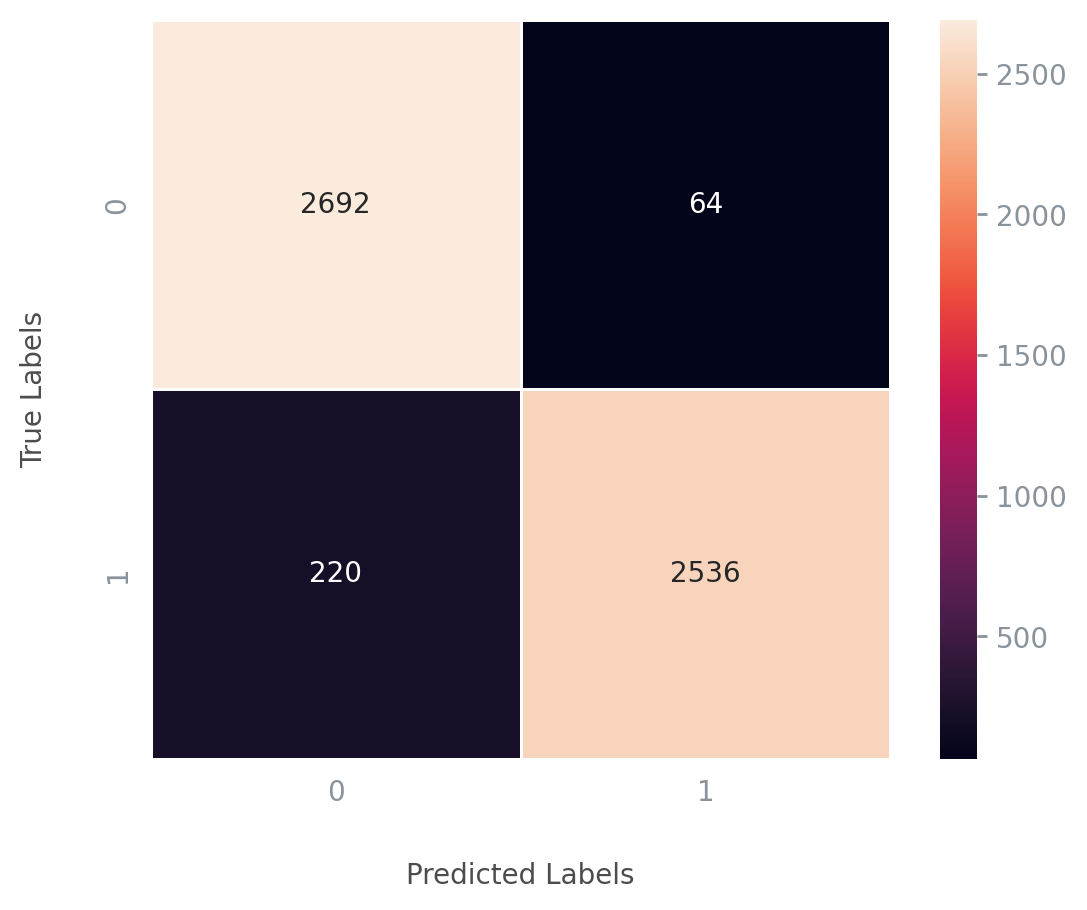

In [93]:
stat_2 = report_and_matrix(test_2, pred_2)

In [22]:
import keras_tuner as kt


def build_model(hp):

    inputs = Input(shape=(64, 64, 3))
    x = inputs

    normalization_conv = hp.Choice("Normalization_conv", ["yes", "no"])
    normalization_dense = hp.Choice("Normalization_dense", ["yes", "no"])

    dropout_conv = hp.Choice("dropout_conv", ["yes", "no"])
    dropout_dense = hp.Choice("dropout_dense", ["yes", "no"])

    rate_dropout_conv = hp.Float(
        "rate_dropout_conv", 0.1, 0.3, step = 0.1, default = 0.3
    )
    rate_dropout_dense = hp.Float(
        "rate_dropout_dense", 0.1, 0.3, step = 0.1, default = 0.3
    )

    for i in range(hp.Int("conv_layers", 2, 3)):
        x = Conv2D(
            filters=hp.Int(
                "filters_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            kernel_size=hp.Int("kernel_size_" + str(i), 2, 4, step = 1),
            activation="relu",
            padding="same"
        )(x)

        x = MaxPooling2D()(x)

        if dropout_conv == "yes":
            x = Dropout(rate = rate_dropout_conv)(x)

        if normalization_conv == "yes":
            x = BatchNormalization()(x)

    x = Flatten()(x)

    for i in range(hp.Int("dense_layers", 1, 3)):
        x = Dense(
            units = hp.Int(
                "neurons_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            activation = "relu",
        )(x)

        if dropout_dense == "yes":
            x = Dropout(rate=rate_dropout_dense)(x)

        if normalization_dense == "yes":
            x = BatchNormalization()(x)

    outputs = Dense(2, activation = "softmax")(x)
    model = Model(inputs, outputs)

    model.compile(
        Adam(learning_rate = 1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model

#### /!\ Work in progress /!\

In [24]:
tuner = kt.Hyperband(
    hypermodel = build_model,
    objective = "val_loss",
    max_epochs = 20,
    directory = ".",
    project_name = "tuner",
    overwrite = True
)

tuner.search(
    augmented_train_data,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data = val_data,
    callbacks = [EarlyStopping(monitor = "val_loss", patience = 3)]
)

models = tuner.get_best_models(num_models=2)

Trial 30 Complete [00h 06m 53s]
val_loss: 0.19048574566841125

Best val_loss So Far: 0.1253087967634201
Total elapsed time: 01h 06m 40s


In [90]:
models[0].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0     

In [49]:
for i, model in enumerate(models):
    new_model = clone_model(model)
    new_model.summary()
    new_model.compile(
        optimizer = Adam(learning_rate = 1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

    histories[f"tuned_model_{i}"] = new_model.fit(
        augmented_train_data,
        epochs = 100,
        batch_size = 32,
        callbacks=checkpoint(WEIGHT_PATH / f"weights_tuned_model_{i}.keras", patience = 3),
        validation_data = val_data,
        verbose = 1,
    )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0     

In [92]:
test_3, pred_3 = prediction(models[0], x_test, y_test_encoded)

173/173 [==============================] - 1s 4ms/step


              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2756
           1       0.97      0.94      0.95      2756

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.95      5512
weighted avg       0.96      0.96      0.95      5512

----------------------------------------------------------------------



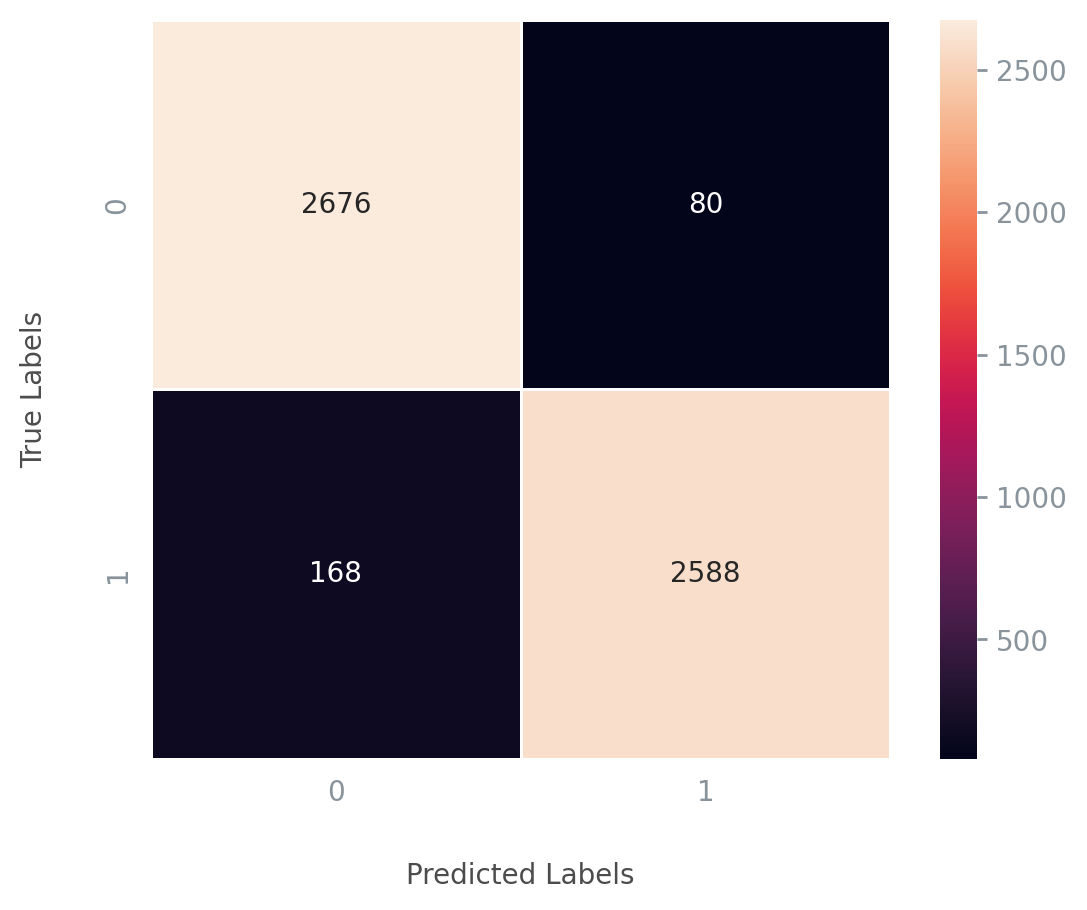

{'report': '              precision    recall  f1-score   support\n\n           0       0.94      0.97      0.96      2756\n           1       0.97      0.94      0.95      2756\n\n    accuracy                           0.96      5512\n   macro avg       0.96      0.96      0.95      5512\nweighted avg       0.96      0.96      0.95      5512\n',
 'matrix': <tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[2676,   80],
        [ 168, 2588]], dtype=int32)>}

In [94]:
report_and_matrix(test_3, pred_3)

In [70]:
import pickle

with open(HISTORIES_PATH / "histories.pkl", "wb") as f:
    pickle.dump(histories, f)

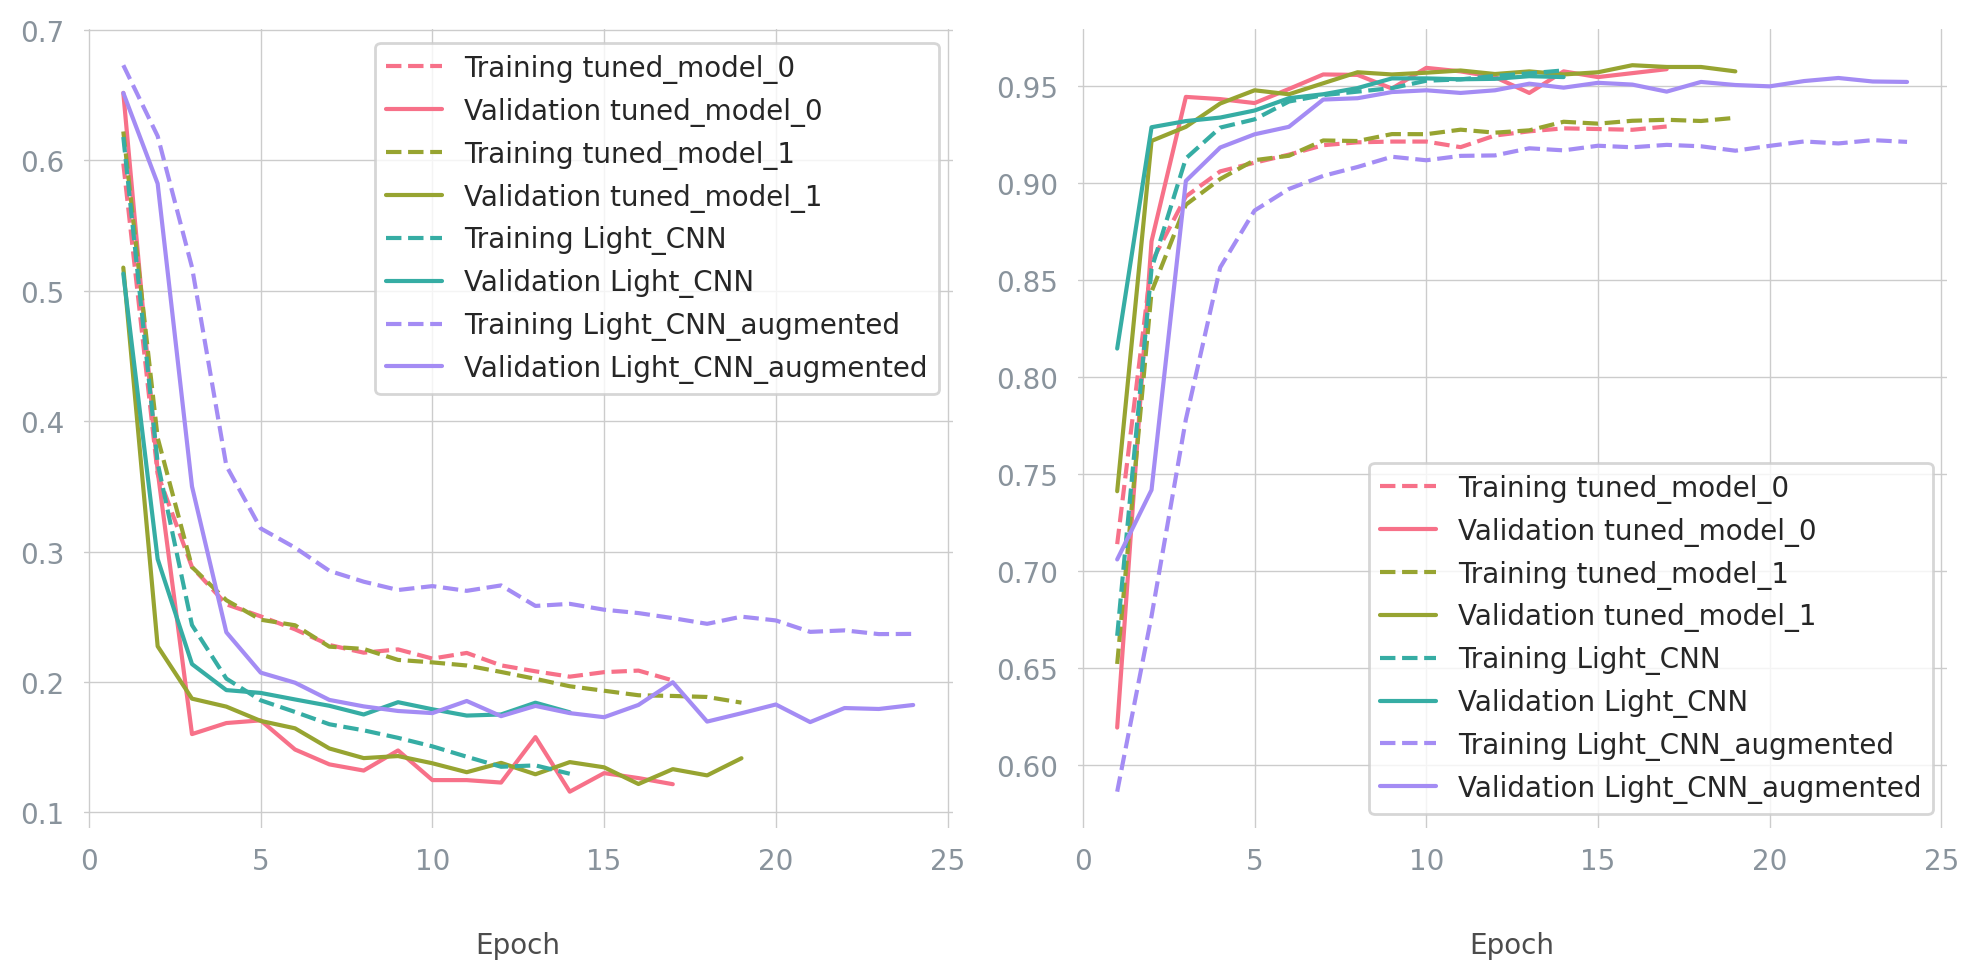

In [95]:
plot_training(histories)